In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import cv2

import glob

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score

C:\Users\Domi\Anaconda2\envs\py35\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Data preparation

## YORO Code (You Only Run Once) for training data preparation

In [ ]:
src = 'data/crowdai/'
image_data = pd.read_csv(src+'labels.csv')
image_data.head()

X_train = []
y_train = []

img_paths = np.unique(image_data.Frame)

n_skip = 5

skip = 0
for img_path in img_paths:
    if skip == n_skip:
        full_path = src + img_path
        img_subset = image_data[image_data.Frame == img_path]

        X_img = plt.imread(full_path)

        y_img = np.zeros_like(X_img)[:,:,0]

        for i in range(len(img_subset)):
            car_loc = img_subset.iloc[i]

            x1, x2, y1, y2 = car_loc.xmin, car_loc.ymin, car_loc.xmax, car_loc.ymax
            y_img[y1:y2, x1:x2] = 1

        X_img = cv2.resize(X_img, (384, 240))
        y_img = cv2.resize(y_img, (384, 240))

        X_train.append(X_img)
        y_train.append(y_img)
        skip = 0
    else:
        skip += 1

# np.save("X_train.npy", X_train)
# np.save("y_train.npy", y_train)

In [2]:
car_files = glob.glob("data/vehicles/*/*.png")
no_car_files = glob.glob("data/non-vehicles/*/*.png")

img_files = np.hstack([car_files, no_car_files])



In [ ]:
img_rows = 4
img_cols = 5

patch_size = 64

for i in range(1000):
    rnd_imgs = np.random.randint(len(no_car_labels), size=img_rows*img_cols)

    counter = 0


    full_img = []

    for row in range(img_rows):
        img_row = []

        for col in range(img_cols):
            file_path = no_car_files[rnd_imgs[counter]]
            img = plt.imread(file_path)
            img_row.append(img)
            counter += 1

        img_row = np.hstack(img_row)
        full_img.append(img_row)

    full_img = np.vstack(full_img)


    car_idx = np.random.randint(len(car_files))
    car_path = car_files[car_idx]
    car_img = plt.imread(car_path)

    car_size = np.random.randint(low=int(patch_size/3), high=patch_size)
    car_img = cv2.resize(car_img, (car_size,car_size))

    car_y = np.random.randint(full_img.shape[0]-car_size)
    car_x = np.random.randint(full_img.shape[1]-car_size)

    full_img[car_y:car_y+car_size, car_x:car_x+car_size] = car_img

    mask = np.zeros_like(full_img)[:,:,0]
    mask[car_y:car_y+car_size, car_x:car_x+car_size] = 1
    
    full_img = cv2.resize(full_img, (X_train[0].shape[1], X_train[0].shape[0]))
    mask = cv2.resize(mask, (X_train[0].shape[1], X_train[0].shape[0]))
    
    X_train.append(full_img*255.)
    y_train.append(mask)

In [ ]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

In [ ]:
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)

In [ ]:
plt.imshow(full_img)
plt.imshow(mask, alpha=0.5)
plt.axis('off')

In [3]:
X_train = np.load("X_train.npy")#.mean(axis=3).astype("float16")
y_train = np.load("y_train.npy")

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],3) / 255.
y_train = y_train.reshape(y_train.shape[0],y_train.shape[1],y_train.shape[2],1)

In [4]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
### The following model is strongly inspired by the one provided by https://github.com/jocicmarko/ultrasound-nerve-segmentation

img_rows = X_train.shape[1]
img_cols = X_train.shape[2]


def iou_loss(y_true, y_pred):
    iou_simple = 2 * K.sum(K.flatten(y_true) *K.flatten(y_pred))
    return -(iou_simple / (K.sum(K.flatten(y_true))+K.sum(K.flatten(y_pred))))

def UNet():
    input = Input((img_rows, img_cols, 3))
    conv_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    conv_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_1)
    pool_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)

    conv_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool_1)
    conv_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_2)
    pool_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool_2)
    conv_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_3)
    pool_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)

    conv_4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool_3)
    conv_4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_4)
    pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

    conv_5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool_4)
    conv_5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv_5)

    unpool_6 = concatenate([UpSampling2D(size=(2, 2))(conv_5), conv_4], axis=3)
    conv_6 = Conv2D(256, (3, 3), activation='relu', padding='same')(unpool_6)
    conv_6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_6)

    unpool_7 = concatenate([UpSampling2D(size=(2, 2))(conv_6), conv_3], axis=3)
    conv_7 = Conv2D(128, (3, 3), activation='relu', padding='same')(unpool_7)
    conv_7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_7)

    unpool_8 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_2], axis=3)
    conv_8 = Conv2D(64, (3, 3), activation='relu', padding='same')(unpool_8)
    conv_8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_8)

    unpool_9 = concatenate([UpSampling2D(size=(2, 2))(conv_8), conv_1], axis=3)
    conv_9 = Conv2D(32, (3, 3), activation='relu', padding='same')(unpool_9)
    conv_9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_9)

    output = Conv2D(1, (1, 1), activation='sigmoid')(conv_9)

    model = Model(inputs=[input], outputs=[output])

    model.compile(optimizer=Adam(lr=1e-4), loss=iou_loss)

    return model

Using TensorFlow backend.


In [5]:
model = UNet()
model.load_weights("new_weights.h5")

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath="weights.h5", verbose=1, save_best_only=True, mode="min")

model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=2, validation_split=0.15, callbacks=[checkpoint])

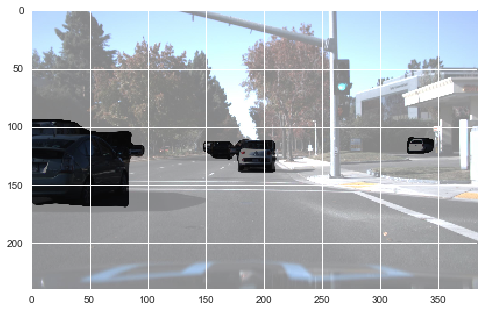

In [6]:
idx = 811
plt.imshow(X_train[idx].astype("float32"))
plt.imshow(model.predict(X_train[idx:idx+1])[0,:,:,0], alpha=0.5)

In [7]:
from scipy.ndimage.measurements import label


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 2)
    # Return the image
    return img

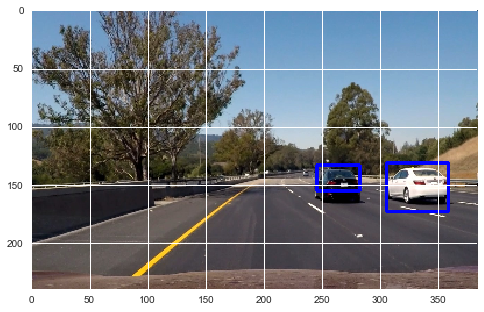

In [11]:
test_files = glob.glob("test_images/*.jpg")

img_orig = plt.imread(test_files[5])
img_orig = cv2.resize(img_orig, (img_cols, img_rows))

img = np.copy(img_orig)

img = cv2.resize(img, (img_cols, img_rows))
img = img/255.
pred = model.predict(img.reshape(1,img_rows, img_cols, 3))[0,:,:,0]

heatmap = apply_threshold(pred, 0.75)
labels = label(heatmap)

draw_img = draw_labeled_bboxes(np.copy(img_orig), labels)
plt.imshow(draw_img, cmap="gray")

In [18]:
def process_frame(img):
    img_orig = np.copy(img)
    img_orig = cv2.resize(img_orig, (img_cols, img_rows))

    img_gray = np.copy(img_orig)

    img_gray = cv2.resize(img_gray, (img_cols, img_rows))
    img_gray = img_gray/255.
    pred = model.predict(img_gray.reshape(1,img_rows, img_cols, 3))[0,:,:,0]
    pred[0:int(pred.shape[0]/2), :] = 0
    heatmap = apply_threshold(pred, 0.85)
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(img_orig), labels)
    return draw_img

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'final_submission.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video final_submission.mp4
[MoviePy] Writing video final_submission.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [00:27<00:00, 45.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final_submission.mp4 

Wall time: 27.8 s


In [ ]:
X_train